<a href="https://colab.research.google.com/github/michalis0/DataMining_and_MachineLearning/blob/master/week12/Dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Machine Learning - Week 12
# Dimensionality Reduction

Dimensionality reduction is the transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data.

Useful for:
* Classification (improve accuracy by removing noise in data)
* Data visualization

### Table of Contents
#### 1. Basic Examples (linear dimensionality reduction)
* 1.1 Visualization with PCA
* 1.2 PCA: exercise
* 1.3 MDS (multi-dimensional scaling)

#### 2. SMS (spam dataset) Classification: with PCA vs. without PCA
* 2.1 Load and explore data
* 2.2 Train test split
* 2.3 Clean and Vectorize text
* 2.4 Logistic regression with and without PCA, normalisation
* 2.5 KNN, with and without PCA, normalisation

#### 3. Text data vizualisation in 2D with t-SNE (non-linear dimensionality reduction)

> t-SNE : t-distributed stochastic neighbor embedding

* 3.1 SMS dataset
* 3.2 Complaints dataset



In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style
plt.style.use('seaborn-deep')

# Set seed
seed = np.random.RandomState(seed=42)

## 1. Basic Examples
We review some of the concepts seen in class using basic examples.

### 1.1 Visualization with PCA

PCA idea: project data points in the lower dimensional space in the direction that retains maximum variance.

<img src='http://lazyprogrammer.me/wp-content/uploads/2015/11/PCA.jpg' width="400">


In the following, we use cancer data that can be found on Kaggle [at this link](https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset).

In [2]:
# Import data
df = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week12/data/Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


We have 5 features (`mean_radius`, `means_texture`, `mean_perimeter`, `mean_area`, `mean_smoothness`) and 1 class (`diagnosis`). We want to use the features to predict the class.

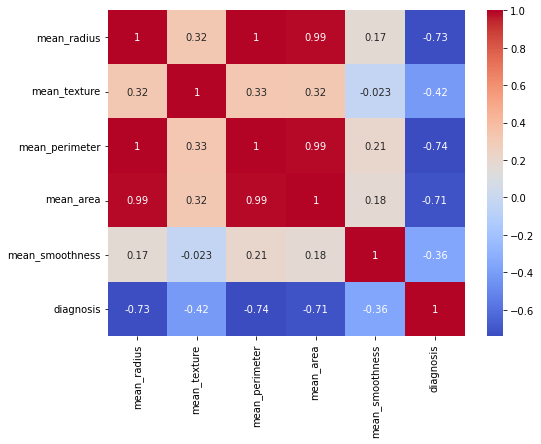

In [3]:
# Correlation
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

There are some high correlations, so PCA may be useful.

In [4]:
# Select features
X = df.drop(['diagnosis'], axis=1)
X.head(2)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
0,17.99,10.38,122.8,1001.0,0.11840
1,20.57,17.77,132.9,1326.0,0.08474


Sometimes PCA works better with Standardization. Try with and without to see the difference.

In [5]:
# Standardize data
from sklearn.preprocessing import StandardScaler

#X = StandardScaler().fit_transform(X)
#X

In [6]:
# Apply PCA on the 5-dimensional X to a lower one of 2 components
from sklearn.decomposition import PCA

# create instance of PCA with the desired number of components
pca = PCA(n_components=2) 

# fit-transform X
result = pd.DataFrame(pca.fit_transform(X), columns=['Principal Component 1', 'Principal Component 2'])

# print results
print(f"Ratio of variance explained by first component: {pca.explained_variance_ratio_[0]:.6f}")
print(f"Ratio of variance explained by second component: {pca.explained_variance_ratio_[1]:.6f}")
print('Ratio of variance explained with the two components together: ', round(sum(pca.explained_variance_ratio_), 6))
result.head()

Ratio of variance explained by first component: 0.999738
Ratio of variance explained by second component: 0.000142
Ratio of variance explained with the two components together:  0.99988


,Principal Component 1,Principal Component 2
0,347.389677,3.453494
1,672.360684,6.223621
2,549.459884,-0.291298
3,-269.152801,-4.103108
4,643.562702,6.210222


In [7]:
# Add diagnosis column to the PCA result data frame
result['diagnosis'] = df['diagnosis']
result.head()

,Principal Component 1,Principal Component 2,diagnosis
0,347.389677,3.453494,0
1,672.360684,6.223621,0
2,549.459884,-0.291298,0
3,-269.152801,-4.103108,0
4,643.562702,6.210222,0


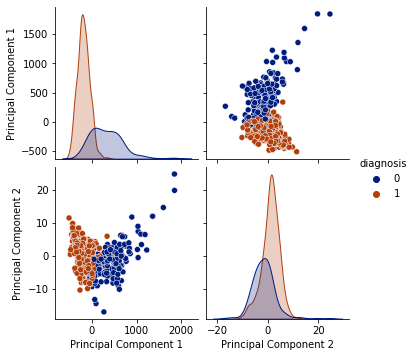

In [8]:
# Plot
sns.pairplot(result, hue='diagnosis', palette='dark')

We can see a clear separation between classes. Indeed, thanks to PCA, we were able to visualise this. It is then easy to apply a classification algorithm. This will have a great precision.

What is the magnitude of each original feature in each principal component?

In [9]:
pca.components_

array([[ 9.86506281e-03,  3.91622032e-03,  6.79638641e-02,
         9.97631323e-01,  7.06404356e-06],
       [-7.71633940e-02, -7.78415813e-01, -6.21277226e-01,
         4.61433705e-02, -1.77206904e-04]])

Here the array values tell us how much the first original feature `mean_radius` influences the first principal component.

In [10]:
pca.feature_names_in_

array(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness'], dtype=object)

In [11]:
# you can also read the components and the feature names as a data frame - easier to read
pd.DataFrame(pca.components_, columns=pca.feature_names_in_, index=['PCA1', 'PCA2'])

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
PCA1,0.009865,0.003916,0.067964,0.997631,0.000007
PCA2,-0.077163,-0.778416,-0.621277,0.046143,-0.000177


Below is a plot of the influence of the different original features of X on the two principal components.

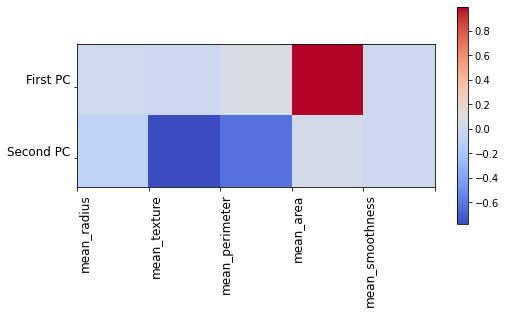

In [12]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'coolwarm')
feature_names = pca.feature_names_in_

plt.gca().set_xticks(np.arange(-.5, len(feature_names)));
plt.gca().set_yticks(np.arange(0.1, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);
plt.colorbar();


The explained variance is an indication of how important each principal component is in describing the distribution of the data.

In [13]:
pca.explained_variance_

array([1.24432259e+05, 1.76637922e+01])

### 1.2 PCA: exercise

We want to further illustrate PCA. For this let's define a function that returns coordinates of a plane.

In [14]:
# Plane function -> ax + by + cz = d + e
def noisy_plane(a, b, c, d, noise, n):
  """Function returns n points belonging to a plane in 3D."""
  # Generate n points
  x = 100*seed.random(n-2)
  x = np.append(x, 200)
  x = np.append(x, 50)
  y = 100*seed.random(n-2)
  y = np.append(y, 50)
  y = np.append(y, 200)
  # Noise
  e = seed.normal(0, noise, n)
  # Calculate the third coordinate of the plane
  z = (d - a*x - b*y + e)/c
  # Make and return DataFrame
  df = pd.DataFrame(np.array([x,y,z])).transpose()
  df.columns = ['x', 'y', 'z']
  return df

# Number of points
n_samples = 500

# Plane with noise of 50
df = noisy_plane(-2, -1, -3, 0, 50, n_samples)
df

,x,y,z
0,37.454012,97.439481,-56.208611
1,95.071431,98.621074,-106.599180
2,73.199394,69.816171,-75.033337
3,59.865848,53.609637,-35.524705
4,15.601864,30.952762,-27.055461
...,...,...,...
495,35.335223,59.023067,-37.957697
496,58.365611,36.097390,-71.161166
497,7.773464,9.158207,-10.596993
498,200.000000,50.000000,-188.655492


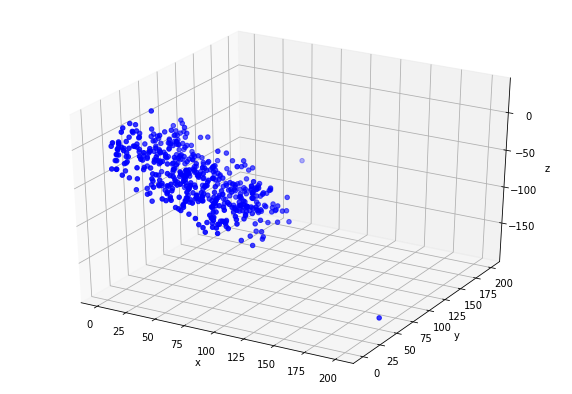

In [15]:
# Plot in 3D
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection="3d")
ax.scatter(df.x, df.y, df.z, color='blue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

We have a plane in three-dimensional space. In addition, we have two points that are a little further away from the plane. We use PCA with 2 components.

In [16]:
# 1. Implement PCA with 2 components and show the components and the explained variance ratio of 
# the first component
# [YOUR CODE HERE]


# create instance of PCA with the desired number of components
pca = PCA(n_components=2) 

# fit-transform X
result = pd.DataFrame(pca.fit_transform(df), columns=['Principal Component 1', 'Principal Component 2'])

# print results
print(f"Ratio of variance explained by first component: {pca.explained_variance_ratio_[0]:.6f}")
print(f"Ratio of variance explained by second component: {pca.explained_variance_ratio_[1]:.6f}")
print('Ratio of variance explained with the two components together: ', round(sum(pca.explained_variance_ratio_), 6))
result.head()

Ratio of variance explained by first component: 0.600250
Ratio of variance explained by second component: 0.341145
Ratio of variance explained with the two components together:  0.941395


,Principal Component 1,Principal Component 2
0,6.236986,50.122430
1,80.713425,32.421080
2,37.177467,12.203702
3,-2.943426,-0.123618
4,-44.576563,-4.728504


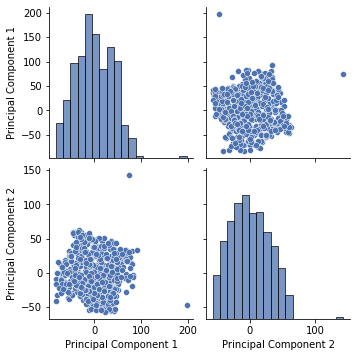

In [17]:
# 2. Plot the two components using a scatter plot. What do you observe?
# [YOUR CODE HERE]
sns.pairplot(result, palette='dark')

### 1.3 MDS
We also provide an example with the multi-dimensional scaling. Idea: achieve lower dimensionality using **distances** between points. In this case the given/available information is a set of distances between objects and we try to figure out the location of these object. 

The documentation file for MDS in sklearn is [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).

First we generate a dataset of points. From it we will find the distances between points. We will only use the distances in MDS.


In [18]:
# Plane without noise
df = noisy_plane(-2, -1, -3, 0, 0, n_samples)
df

,x,y,z
0,8.912443,71.024280,-29.616389
1,75.527042,31.435011,-60.829698
2,12.771348,47.116790,-24.219829
3,82.606763,82.163690,-82.459072
4,78.202809,45.926520,-67.444046
...,...,...,...
495,85.817705,76.103779,-82.579730
496,81.906351,95.077271,-86.296658
497,54.079375,70.254050,-59.470934
498,200.000000,50.000000,-150.000000


In [19]:
# Standardize data - because we calculate distances
df_standardized = StandardScaler().fit_transform(df)
df_standardized

array([[-1.39175101e+00,  7.11474161e-01,  9.13650843e-01],
       [ 8.40164808e-01, -6.36288101e-01, -4.62293044e-01],
       [-1.26245875e+00, -1.02423492e-01,  1.15154178e+00],
       ...,
       [ 1.21562775e-01,  6.85252749e-01, -4.02396029e-01],
       [ 5.01061945e+00, -4.26856457e-03, -4.39309476e+00],
       [-1.51163138e-02,  5.10227537e+00, -2.18899673e+00]])

In [20]:
df_standardized.shape

(500, 3)

▶ Small recap on Euclidean distances, for example distance between points **p** and **q** in the graph below.  

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Euclidean_distance_2d.svg/1200px-Euclidean_distance_2d.svg.png' width="300">

In [21]:
# Compute distances between points in the dataset we generated
from sklearn.metrics import euclidean_distances

similarities = euclidean_distances(df_standardized)
similarities[:3]

array([[0.        , 2.94807274, 0.8577517 , ..., 2.00568829, 8.34650729,
        5.54983606],
       [2.94807274, 0.        , 2.70379365, ..., 1.50547227, 5.76570401,
        6.05343887],
       [0.8577517 , 2.70379365, 0.        , ..., 2.2250106 , 8.37282144,
        6.30903725]])

In [22]:
similarities.shape

(500, 500)

In [23]:
# Add noise to distances
noise = (np.random.rand(n_samples, n_samples) - 0.5)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise
similarities[:3]

array([[0.        , 2.68076423, 0.77781211, ..., 2.13980992, 8.51167112,
        5.62803319],
       [2.68076423, 0.        , 2.78585006, ..., 1.01175586, 5.53971905,
        6.76358446],
       [0.77781211, 2.78585006, 0.        , ..., 2.21634305, 8.391709  ,
        6.64475107]])

In [24]:
# MDS
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=100000, eps=1e-12, random_state=seed,
                   dissimilarity='precomputed', n_jobs=-1)
pos = pd.DataFrame(mds.fit_transform(similarities), columns=['Component 1', 'Component 2'])
pos

,Component 1,Component 2
0,-1.302248,1.221401
1,0.747458,-0.934679
2,-1.622189,0.470281
3,2.029070,0.545556
4,1.110899,-0.535359
...,...,...
495,2.042761,0.241679
496,2.248078,0.925758
497,0.535760,0.535689
498,6.358543,-2.073894


Text(0, 0.5, 'Component 2')

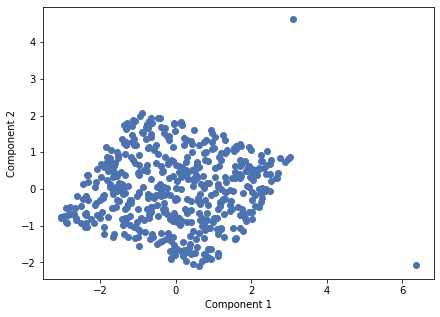

In [25]:
# Plot projection
plt.figure(figsize=(7,5))
plt.scatter(pos['Component 1'], pos['Component 2'])
plt.xlabel('Component 1')
plt.ylabel('Component 2')

## 2. SMS Classification: with vs. without PCA
We classify SMS as `ham` or `spam` using logistic regression and KNN with and without PCA. Data can be found [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

### 2.1 Load and explore data

In [26]:
# Load data from GitHub
path = "https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week12/data/spam.csv"
data = pd.read_csv(path, encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


We want to predict the label (v1) based on the text of the message (v2).

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [28]:
# Select text only
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
data = data.rename(columns = {'v1':'label','v2':'message'})
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [30]:
# A bit of EDA
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

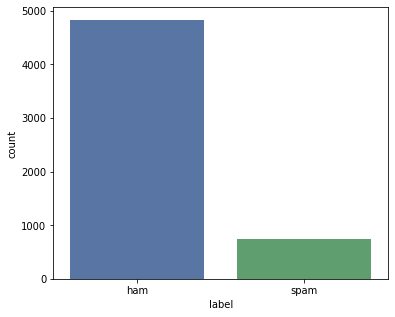

In [31]:
# Imbalanced dataset
plt.figure(figsize=(6,5))
sns.countplot(x=data.label)
plt.show()

In [32]:
# Class frequencies
data.label.value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [33]:
# Select variables
X = data.message
y = data.label

### 2.2 Train test split


In [34]:
# Import function
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
X_train

1869                       Mom wants to know where you at
1270    Sorry chikku, my cell got some problem thts y ...
698                        Mum ask Ì_ to buy food home...
1385    That's ok. I popped in to ask bout something a...
2628    Haha... They cant what... At the most tmr forf...
                              ...                        
3951    Me hungry buy some food good lei... But mum n ...
2885                   No probs hon! How u doinat the mo?
3941                  She's borderline but yeah whatever.
5166    Y she dun believe leh? I tot i told her it's t...
4568                  At WHAT TIME should i come tomorrow
Name: message, Length: 4457, dtype: object

### 2.3 Clean and vectorize text
We use the `re` and `nltk` packages for cleaning.

In [35]:
# Import and download packages
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords


# Define cleaning function
def data_cleaner(sms):

    # Define stopwords
    stop_words = stopwords.words('english')

    # Define tokenizer and stemmer
    from nltk.tokenize import word_tokenize
    from nltk.stem import PorterStemmer
    
    # Remove digits
    sms = re.sub(r"\d+","", sms)
    
    # Lowercase
    sms = sms.lower()
    
    # Remove punctuation
    sms = re.sub(r"[^\w\s\d]","", sms)
    
    # Remove stop words
    sms = sms.split()
    sms = " ".join([word for word in sms if not word in stop_words])
    
    # Tokenize
    sms = word_tokenize(sms)
    
    # Stemming
    ps = PorterStemmer()
    sms = [ps.stem(word) for word in sms]
    
    return sms

# Clean X_train as example
X_train.apply(data_cleaner)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


1869                                    [mom, want, know]
1270    [sorri, chikku, cell, got, problem, tht, nt, a...
698                       [mum, ask, ì_, buy, food, home]
1385    [that, ok, pop, ask, bout, someth, said, youd,...
2628                     [haha, cant, tmr, forfeit, haha]
                              ...                        
3951    [hungri, buy, food, good, lei, mum, n, yun, du...
2885                           [prob, hon, u, doinat, mo]
3941                       [she, borderlin, yeah, whatev]
5166    [dun, believ, leh, tot, told, true, alreadi, t...
4568                               [time, come, tomorrow]
Name: message, Length: 4457, dtype: object

It's not perfect but it's already great :) 
We further use TF-IDF to vectorize the messages.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define vectorizer - use above cleaning function
tfidf = TfidfVectorizer(sublinear_tf=True, tokenizer=data_cleaner, ngram_range=(1,1), min_df=3, max_df=0.9)

# Fit and transform X_train and X_test
X_train_vec = tfidf.fit_transform(X_train).toarray()
X_test_vec = tfidf.transform(X_test).toarray()
print(X_train_vec.shape)
X_train_vec

(4457, 1957)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

As we can see, `X_train_vec` has a dimensionality of 1957. We use PCA to lower this to 100.

### 2.4 PCA

In [37]:
# Define PCA
pca = PCA(n_components=100)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)
print('Shape after PCA: ', X_train_vec_pca.shape)
print('Number of components: ', pca.n_components_)
print('Explained variance ratio: ', sum(pca.explained_variance_ratio_))

Shape after PCA:  (4457, 100)
Number of components:  100
Explained variance ratio:  0.32955733748562155


### 2.5 Logistic Regression
We apply logistic regression 4 times:
* Without PCA and Standardization
* With Standardization
* With PCA
* With Standardization and PCA

We then compare the time to run and the accuracy on training and test sets.

In [38]:
# Without PCA and Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Model
pipe = Pipeline([
                 ('logistic reg', LogisticRegression())
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  1.097
Train Accuracy:  0.9731
Test Accuracy:  0.9695


In [39]:
# With Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import time

# Define Scaler
scaler = StandardScaler()

# Define Model
pipe = Pipeline([('scaler', scaler),
                 ('logistic reg', LogisticRegression())
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  1.071
Train Accuracy:  0.9998
Test Accuracy:  0.9857


In [40]:
# With PCA

# Define Model
pipe = Pipeline([
                 ('pca', pca),
                 ('logistic reg', LogisticRegression()),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  2.7407
Train Accuracy:  0.9554
Test Accuracy:  0.9605


In [41]:
# With PCA and standardization

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('logistic reg', LogisticRegression(max_iter=3000)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  2.9102
Train Accuracy:  0.9847
Test Accuracy:  0.9785


We can see that the best results are obtained in the second case:
* With Standardization

In this case, standardization increases the performance, but PCA does not.

### 2.6 KNN
We apply KNN 4 times:
* Without PCA
* With Standardization
* With PCA
* With Standardization and PCA

We then compare the time to run and the accuracy on training and test sets.

In [42]:
# Change number of components - only 10
pca = PCA(n_components=10)

In [43]:
# Without PCA and Standardization
from sklearn.neighbors import KNeighborsClassifier

# Define Model
pipe = Pipeline([
                 ('knn', KNeighborsClassifier(15)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  0.0154
Train Accuracy:  0.8874
Test Accuracy:  0.8709


In [44]:
# With Standardization

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('knn', KNeighborsClassifier(15)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  0.1251
Train Accuracy:  0.8791
Test Accuracy:  0.8646


In [45]:
# With PCA

# Define Model
pipe = Pipeline([
                 ('pca', pca),
                 ('knn', KNeighborsClassifier(15)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  1.25
Train Accuracy:  0.9632
Test Accuracy:  0.9605


In [46]:
# With PCA and standardization

# Define Model
pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('knn', KNeighborsClassifier(15)),
                 ])
# Fit model
start = time.time()
pipe.fit(X_train_vec, y_train)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec, y_train), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec, y_test), 4))

Time:  1.4377
Train Accuracy:  0.9742
Test Accuracy:  0.9605


In this case, PCA increases the accuraccy but standardization does not. In addition, the time to run is lower with PCA.

#### Conclusion: PCA and standardization are useful tools that could help increase the accuracy and/or lower execution time.

## 3. Text data vizualisation with t-SNE
Finally, we show t-SNE. Documentation is available [at this link](https://www.scikit-yb.org/en/latest/api/text/tsne.html) for the TSNEVisualiser (always in 2D) and [at this link](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for TSNE in sklearn.

### 3.1 SMS
We use the train data.

In [47]:
X = pd.DataFrame(X_train_vec)
X

,0,1,2,3,4,5,6,7,8,9,...,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.321376,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.37631,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.331022,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4453,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4454,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4455,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [48]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
X_proj_tsne = tsne.fit_transform(X_train_vec)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


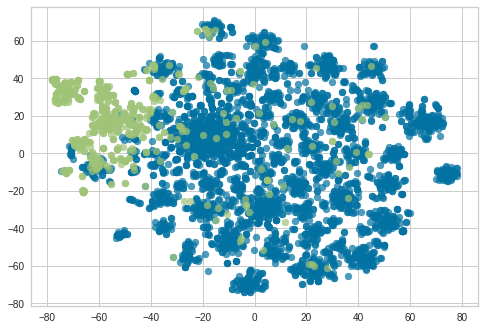

In [49]:
from yellowbrick.text import TSNEVisualizer
# Create the visualizer and draw the vectors
tsne_viz = TSNEVisualizer(labels=y_train.unique())
tsne_viz.fit(X_train_vec, y_train);

In only 2 dimensions, we can already see the two classes.

### 3.2 Complaints
The data we are using here is available under the "data" folder in "week10" on the git. 

In [52]:
# Import, clean, prepare
path = "https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week10/data/complaints_sample.csv"
df = pd.read_csv(path, index_col=0)

# Select columns of interest
data = df[["Product", "Consumer complaint narrative"]]
data.head()

# Drop NaN
print(data.isnull().sum())
data = data.dropna().reset_index(drop=True)
data.head()

# Clean
dic_replace = {'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports', 
               'Credit card':'Credit card or prepaid card', 
               'Payday loan':'Payday loan, title loan, or personal loan', 
               'Money transfers':'Money transfer, virtual currency, or money service',
               'Prepaid card':'Credit card or prepaid card',
               'Virtual currency':'Money transfer, virtual currency, or money service'}
data.replace(dic_replace, inplace=True)
data.Product.value_counts()

Product                            0
Consumer complaint narrative    5964
dtype: int64


Credit reporting, credit repair services, or other personal consumer reports    1290
Debt collection                                                                  640
Mortgage                                                                         378
Credit card or prepaid card                                                      291
Student loan                                                                     129
Checking or savings account                                                      119
Money transfer, virtual currency, or money service                                72
Bank account or service                                                           64
Vehicle loan or lease                                                             57
Payday loan, title loan, or personal loan                                         55
Consumer Loan                                                                     38
Other financial service                                          

In [53]:
import spacy
import string

# Load English language model of spacy
sp = spacy.load('en_core_web_sm')


# Define tokenizer function
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.en.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Remove anonymous dates and people
    mytokens = [ word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in ["xxxx", "xx", ""] ]

    # Return preprocessed list of tokens
    return mytokens

# Select features
X = data['Consumer complaint narrative'] # the features we want to analyze
ylabels = data['Product'] # the labels, or answers, we want to test against

# Define vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Vectorize
X_vec = tfidf.fit_transform(X)
X_vec = pd.DataFrame(X_vec.toarray())
X_vec

,0,1,2,3,4,5,6,7,8,9,...,8102,8103,8104,8105,8106,8107,8108,8109,8110,8111
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


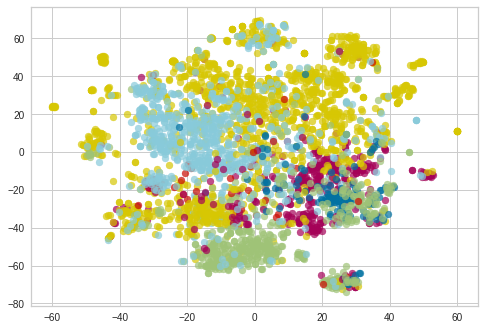

In [54]:
# t-sne
# Create the visualizer and draw the vectors
tsne_viz = TSNEVisualizer()
tsne_viz.fit(X_vec, ylabels);


Here we see a bit of the clusters but since we have 12 classes it is not as straight-forward.

## References

* https://www.kaggle.com/shahraizanwar/covid19-tweets-sentiment-prediction-rnn-85-acc
* https://www.kaggle.com/datatattle/battle-of-ml-classification-models

